# Programming Exercise 4: Neural Networks Learning
In this exercise, you will implement the backpropagation algorithm for neural
networks and apply it to the task of hand-written digit recognition.

In [1]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Neural Networks
In the previous exercise, you implemented feedforward propagation for neural
networks and used it to predict hand-written digits with the weights we provided.
In this exercise, you will implement the backpropagation algorithm to *learn*
the parameters for the neural network.

In [2]:
# Loading data
data = loadmat('ex4data1.mat')

# training data stored in arrays X, y
X, y = data['X'], data['y']

# set the zero digit to 0, rather than its mapped 10 in this dataset
y[y == 10] = 0

# Number of training examples
m = y.size

### 1.1 Visualizing the data
You will begin by visualizing a subset of the training set, using the function
`displayData`, which is the same function we used in Exercise 3. The dataset is
also the same one you used in the previous exercise.

In [3]:
def displayData(X, figsize=(8, 8)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        m, n = 1, X.size
        X = X[None] # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_size = int(np.round(np.sqrt(n)))

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, axes = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    axes = [axes] if m == 1 else axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(X[i].reshape(example_size, example_size, order='F'),
                  cmap='binary', extent=[0, 1, 0, 1])
        ax.axis('off')

There are 5000 training examples in `ex4data1.mat`, where each training example
is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented
by a floating point number indicating the grayscale intensity at that location.
The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of
these training examples becomes a single row in our data matrix $X$. This gives
us a 5000 by 400 matrix $X$ where every row is a training example for a
hand-written digit image.

\begin{equation}
X=\left[\begin{array}{c}
-\left(x^{(1)}\right)^{T}- \\
-\left(x^{(2)}\right)^{T}- \\
\vdots \\
-\left(x^{(m)}\right)^{T}-
\end{array}\right]
\end{equation}

The second part of the training set is a 5000-dimensional vector $y$ that
contains labels for the training set. The following cell randomly selects
100 images from the dataset and plots them.

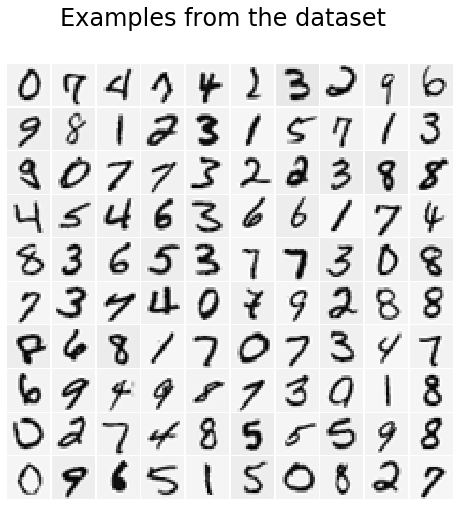

In [4]:
# Randomly select 100 data points to display
X_random = X[np.random.choice(m, 100), :]
displayData(X_random)
plt.suptitle('Examples from the dataset', fontsize=24);

### 1.2 Model representation
Our neural network is shown in the following figure.

![NkuVmQ.png](https://s1.ax1x.com/2020/06/16/NkuVmQ.png)

It has 3 layers: an input layer, a hidden layer and an output layer. Recall
that our inputs are pixel values of digit images. Since images are of size
$20 \times 20$, this gives us 400 input layer units (excluding the extra bias
unit which always outputs +1). As before, the training data will be loaded into
the variables $X$ and $y$ above.

You have been provided with a set of network parameters $(\Theta^{(1)},\Theta^{(2)})$
already trained by us. These are stored in `ex4weights.mat` and will be loaded
in the next cell into `Theta1` and `Theta2`. The parameters have dimensions
that are sized for a neural network with 25 units in the second layer and 10
output units (corresponding to the 10 digit classes).

In [5]:
# Setup the parameters you will use for this exercise
input_layer_size = 400      # 20x20 input images of digits
hidden_layer_size = 25      # 25 hidden units
num_labels = 10             # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary
weights = loadmat('ex4weights.mat')

# Get the model weights from the dictionary
# Theta1 has size 25 x 401, Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# Swap first and last columns of Theta2, due to legacy from MATLAB indexing,
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters
nn_params = np.r_[Theta1.ravel(order='F'), Theta2.ravel(order='F')]

### 1.3 Feedforward and cost function
Now you will implement the cost function and gradient for the neural network.
First, complete the code for the function `nnCostFunction` in the next cell to
return the cost.

Recall that the cost function for the neural network (without regularization) is

\begin{equation}
J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K}
\left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right)
- \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]
\end{equation}

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural
network figure above, and $K = 10$ is the total number of possible labels.
Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of
the $k^{\text{th}}$ output unit. Also, recall that whereas the original labels
(in the variable $y$) were 0, 1, ..., 9, for the purpose of training a neural
network, we need to encode the labels as vectors containing only values 0 or 1,
so that

$$y = \begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad \begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad \begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}. $$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding
$y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional
vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$
for every example $i$ and sum the cost over all examples. Your code should also
work for a dataset of any size, with any number of labels (you can assume that
there are always at least $K \ge 3$ labels).

In [6]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    """
    g = 1 / (1 + np.exp(-z))
    return g

def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z.
    """
    return sigmoid(z) * (1 - sigmoid(z))

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural
    network which performs classification.

    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into a vector.
        This needs to be converted back into the weight matrices Theta1 and Theta2.

    input_layer_size : int
        Number of features for the input layer.

    hidden_layer_size : int
        Number of hidden units in the second layer.

    num_labels : int
        Total number of labels, or equivalently number of units in output layer.

    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).

    y : array_like
        Dataset labels. A vector of shape (m,).

    lambda_ : float, optional
        Regularization parameter.

    Returns
    -------
    cost : float
        The computed value for the cost function at the current weight values.

    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation
        of neural network weights Theta1 and Theta2.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2 (the weight
    # matrices for the 2 layer neural network)
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        [hidden_layer_size, (input_layer_size + 1)], order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],
                        [num_labels, (hidden_layer_size + 1)], order='F')

    # Setup some useful variables
    m = y.size

    # Feedforward propagation
    a1 = np.c_[np.ones([m, 1]), X]
    z2 = np.dot(a1, Theta1.T)
    a2 = np.c_[np.ones([z2.shape[0], 1]), sigmoid(z2)]
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    y = np.eye(num_labels)[y.reshape(-1)]

    # Add regularization term
    cost1 = - np.sum(np.log(a3) * y + np.log(1 - a3) * (1 - y)) / m
    cost2 = 0.5 * lambda_ * (np.sum(np.square(Theta1[:, 1:])) +
                             np.sum(np.square(Theta2[:, 1:]))) / m
    cost = cost1 + cost2

    # Backpropagation
    delta3 = a3 - y
    delta2 = np.dot(delta3, Theta2)[:, 1:] * sigmoidGradient(z2)
    Delta1, Delta2 = np.dot(delta2.T, a1), np.dot(delta3.T, a2)

    # Add regularization to gradient
    Theta1_grad = Delta1 / m
    Theta1_grad[:, 1:] += lambda_ * Theta1[:, 1:] / m
    Theta2_grad = Delta2 / m
    Theta2_grad[:, 1:] += lambda_ * Theta2[:, 1:] / m

    # Unroll gradients
    grad = np.r_[Theta1_grad.ravel(order='F'), Theta2_grad.ravel(order='F')]

    return cost, grad

Once you are done, call your `nnCostFunction` using the loaded set of parameters
for `Theta1` and `Theta2`. You should see that the cost is about 0.287629.

In [7]:
cost, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                         num_labels, X, y, lambda_=0.0)
print('Cost at loaded parameters: {:.6f}'.format(cost))
print('The value should be about:  0.287629')

Cost at loaded parameters: 0.287629
The value should be about:  0.287629


### 1.4 Regularized cost function
The cost function for neural networks with regularization is given by

\begin{aligned}
J(\theta)=& \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K}\left[-y_{k}^{(i)} \log \left(\left(h_{\theta}\left(x^{(i)}\right)\right)_{k}\right)-\left(1-y_{k}^{(i)}\right) \log \left(1-\left(h_{\theta}\left(x^{(i)}\right)\right)_{k}\right)\right]+\\
& \frac{\lambda}{2 m}\left[\sum_{j=1}^{25} \sum_{k=1}^{400}\left(\Theta_{j, k}^{(1)}\right)^{2}+\sum_{j=1}^{10} \sum_{k=1}^{25}\left(\Theta_{j, k}^{(2)}\right)^{2}\right]
\end{aligned}

You can assume that the neural network will only have 3 layers - an input
layer, a hidden layer and an output layer. However, your code should work for
any number of input units, hidden units and outputs units.
While we have explicitly listed the indices above for
$\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should
in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size. Note that
you should not be regularizing the terms that correspond to the bias. For the
matrices `Theta1` and `Theta2`, this corresponds to the first column of each
matrix. You should now add regularization to your cost function. Notice that
you can first compute the unregularized cost function $J$ using your existing
`nnCostFunction` and then later add the cost for the regularization terms.

Once you are done, the next cell will call your nnCostFunction using the loaded
set of parameters for `Theta1` and `Theta2`, and $\lambda = 1$. You should see
that the cost is about 0.383770.

In [8]:
# Weight regularization parameter (we set this to 1 here)
cost, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                         num_labels, X, y, lambda_=1.0)
print('Cost at loaded parameters: {:.6f}'.format(cost))
print('The value should be about: 0.383770')

Cost at loaded parameters: 0.383770
The value should be about: 0.383770


## 2 Backpropagation
In this part of the exercise, you will implement the backpropagation algorithm
to compute the gradient for the neural network cost function. You will need to
update the function `nnCostFunction` so that it returns an appropriate value
for `grad`. Once you have computed the gradient, you will be able to train the
neural network by minimizing the cost function $J(\theta)$ using an advanced
optimizer such as scipy's `optimize.minimize`. You will first implement the
backpropagation algorithm to compute the gradients for the parameters for the
(unregularized) neural network. After you have verified that your gradient
computation for the unregularized case is correct, you will implement the
gradient for the regularized neural network.
### 2.1 Sigmoid gradient
To help you get started with this part of the exercise, you will first
implement the sigmoid gradient function. The gradient for the sigmoid function
can be computed as

$$g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right)$$

where

$$\text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}}$$

The implementation of `sigmoidGradient` has been completed in the previous cell.
The following cell call `sigmoidGradient` on a given vector $z$. Try testing a
few values by calling `sigmoidGradient(z)`. For large values (both positive and
negative) of $z$, the gradient should be close to 0. When $z = 0$, the gradient
should be exactly 0.25. Your code should also work with vectors and matrices.
For a matrix, your function should perform the sigmoid gradient function on
every element.

In [9]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


### 2.2 Random initialization
When training neural networks, it is important to randomly initialize the
parameters for symmetry breaking. One effective strategy for random initialization
is to randomly select values for $\Theta^{(l)}$ uniformly in the range
$[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$.
This range of values ensures that the parameters are kept small and makes the
learning more efficient.

Your job is to complete the function `randInitializeWeights` to initialize the
weights for $\Theta$. Note that we give the function an argument for
$\epsilon$ with default value epsilon_init = 0.12.

In [10]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.

    Parameters
    ----------
    L_in : int
        Number of incomming connections.

    L_out : int
        Number of outgoing connections.

    epsilon_init : float, optional
        Range of values which the weight can take from a uniform
        distribution.

    Returns
    -------
    W : array_like
        The weight initialized  to random values.
        Note that W should be set to a matrix of size(L_out, 1 + L_in) as the
        first column of W handles the "bias" terms.
    """
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

Execute the following cell to initialize the weights for the 2 layers in the
neural network using the `randInitializeWeights` function.

In [11]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.r_[initial_Theta1.ravel(order='F'), initial_Theta2.ravel(order='F')]

Initializing Neural Network Parameters ...


### 2.3 Backpropagation
![NZvJC4.png](https://s1.ax1x.com/2020/06/18/NZvJC4.png)

Now, you will implement the backpropagation algorithm. Recall that the
intuition behind the backpropagation algorithm is as follows. Given a training
example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all
the activations throughout the network, including the output value of the
hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like
to compute an “error term” $\delta_j^{(l)}$ that measures how much that node
was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s
activation and the true target value, and use that to define $\delta_j^{(3)}$
(since layer 3 is the output layer). For the hidden units, you will compute
$\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in
layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted
in the figure above). You should implement steps 1 to 4 in a loop that processes
one example at a time. Concretely, you should implement a for-loop
`for t in range(m)` and place steps 1-4 below inside the for-loop, with the
$t^{th}$ iteration performing the calculation on the $t^{th}$ training example
$(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to
obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example
$x^{(t)}$. Perform a feedforward pass, computing the activations
$(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3.
Note that you need to add a `+1` term to ensure that the vectors of activations
for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit.

2. For each output unit $k$ in layer 3 (the output layer), set
\begin{equation}
\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)
\end{equation}
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs
to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$.
You may find logical arrays helpful for this task (explained in the previous
programming exercise).

3. For the hidden layer $l = 2$, set
\begin{equation}
\delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)
\end{equation}
Note that the symbol $*$ performs element wise multiplication in `numpy`.

4. Accumulate the gradient from this example using the following formula.
Note that you should skip or remove $\delta_0^{(2)}$.

5. Obtain the (unregularized) gradient for the neural network cost function by
dividing the accumulated gradients by $\frac{1}{m}$:
\begin{equation}
\frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}
\end{equation}

After you have implemented the backpropagation algorithm, we will proceed to
run gradient checking on your implementation. The gradient check will allow you
to increase your confidence that your code is computing the gradients correctly.

### 2.4 Gradient checking
In your neural network, you are minimizing the cost function $J(\Theta)$. To
perform gradient checking on your parameters, you can imagine “unrolling” the
parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$.
By doing so, you can think of the cost function being $J(\Theta)$ instead and
use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes
$\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is
outputting correct derivative values.

$$ \text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix} \quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix} $$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{\text{th}}$ element
has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding
vector with the $i^{\text{th}}$ element decreased by $\epsilon$. You can now
numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

The degree to which these two values should approximate each other will depend
on the details of $J$. But assuming $\epsilon = 10^{-4}$, you’ll usually find
that the left- and right-hand sides of the above will agree to at least 4
significant digits (and often many more).

You can use the function `computeNumericalGradient` to compute the numerical gradient.

In [12]:
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical
    estimate of the gradient.
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1) / (2 * e)
    return numgrad

Function `checkNNGradients` creates a small neural network and dataset that
will be used for checking your gradients.

In [13]:
def debugInitWeights(fan_in, fan_out):
    """
    Initialize the weights of a layer with fan_in incoming connections and
    fan_out outgoings connections using a fixed strategy. This will help you
    later in debugging.
    """
    # Initialize W using "sin", this ensures that W is always of the same values
    # and will be useful for debugging
    W = np.sin(np.arange(1, 1 + (1 + fan_in) * fan_out)) / 10.0
    W = W.reshape(fan_out, 1 + fan_in, order='F')
    return W

def checkNNGradients(nnCostFunction, lambda_=0, visually_examine=False):
    """
    Creates a small neural network to check the backpropagation gradients.
    It will output the analytical gradients produced by your backpropagation code
    and the numerical gradients (computed using `computeNumericalGradient`).
    These two gradient computations should result in very similar values.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitWeights(input_layer_size, hidden_layer_size)
    Theta2 = debugInitWeights(hidden_layer_size, num_labels)
    # Reusing debugInitWeights to generate X
    X = debugInitWeights(input_layer_size - 1, m)
    y = np.arange(1, 1 + m) % num_labels

    # Unroll parameters
    nn_params = np.r_[Theta1.ravel(order='F'), Theta2.ravel(order='F')]

    # Short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.
    # The two columns you get should be very similar
    if (visually_examine):
        print(np.stack([numgrad, grad], axis=1))
        print(' - The above two columns you get should be very similar.')
        print(' - (Left: Your Numerical Gradient; Right: Analytical Gradient)')

    # Evaluate the norm of the difference between two solutions.
    # If you have a correct implementation, and assuming that you used EPSILON = 1e-4
    # in 'computeNumericalGradient()', then diff below should be less that 1e-9
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print(' - If your backpropagation implementation is correct, \n'
          ' - then the relative difference will be small (less than 1e-9).\n'
          ' - Relative Difference: {:.6g}'.format(diff))

In the next cell we will run the function checkNNGradients. If your
backpropagation implementation is correct, you should see a relative difference
that is less than 1e-9.

In [14]:
checkNNGradients(nnCostFunction, visually_examine=True)
debug_cost, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                               num_labels, X, y, lambda_=0)

[[-9.27825235e-03 -9.27825236e-03]
 [ 8.89911959e-03  8.89911960e-03]
 [-8.36010761e-03 -8.36010762e-03]
 [ 7.62813550e-03  7.62813551e-03]
 [-6.74798369e-03 -6.74798370e-03]
 [-3.04978487e-06 -3.04978914e-06]
 [ 1.42869427e-05  1.42869443e-05]
 [-2.59383093e-05 -2.59383100e-05]
 [ 3.69883235e-05  3.69883234e-05]
 [-4.68759764e-05 -4.68759769e-05]
 [-1.75060084e-04 -1.75060082e-04]
 [ 2.33146358e-04  2.33146357e-04]
 [-2.87468731e-04 -2.87468729e-04]
 [ 3.35320351e-04  3.35320347e-04]
 [-3.76215583e-04 -3.76215587e-04]
 [-9.62660640e-05 -9.62660620e-05]
 [ 1.17982666e-04  1.17982666e-04]
 [-1.37149709e-04 -1.37149706e-04]
 [ 1.53247082e-04  1.53247082e-04]
 [-1.66560292e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 9.74006970e-02  9.74006970e-02]
 [ 1.64090819e-01  1.64090819e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.04575855e-02  5.04575855e-02]
 [ 1.64567932e-01  1.64567932e-01]
 [ 5.77867378e-02  5.77867378e-02]
 [ 5.07530173e-02  5

### 2.5 Regularized Neural Network
After you have successfully implemented the backpropagation algorithm, you will
add regularization to the gradient. To account for regularization, it turns out
that you can add this as an additional term after computing the gradients using
backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation,
you should add regularization using

\begin{align}
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}

Note that you should not be regularizing the first column of $\Theta^{(l)}$
which is used for the bias term. Furthermore, in the parameters
$\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting
from 0. Thus,

$$ \Theta^{(l)} = \begin{bmatrix} \Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\ \Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\ \vdots &  \sim & \ddots \end{bmatrix} $$

Now modify your code that computes grad in `nnCostFunction` to account for
regularization.

After you are done, the following cell runs gradient checking on your
implementation. If your code is correct, you should expect to see a relative
difference that is less than 1e-9.

In [15]:
lambda_ = 3.0
checkNNGradients(nnCostFunction, lambda_=lambda_, visually_examine=False)
cost, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                               num_labels, X, y, lambda_)

print('\nCost at (fixed) debugging parameters (lambda = {:.1f}): {:.6f}'
      '\n - (for lambda = 3, this value should be about 0.576051)'.
      format(lambda_, cost))

 - If your backpropagation implementation is correct, 
 - then the relative difference will be small (less than 1e-9).
 - Relative Difference: 2.4815e-11

Cost at (fixed) debugging parameters (lambda = 3.0): 0.576051
 - (for lambda = 3, this value should be about 0.576051)


### Learning parameters using `scipy.optimize.minimize`
After you have successfully implemented the neural network cost function and
gradient computation, the next step we will use `scipy`'s minimization to learn
a good set parameters.

In [16]:
# After you have completed the assignment, change the MaxIter to a larger
# value to see how training helps
options = {'maxiter': 1000}

# You should also try different values of lambda
train_lambda = 1.0

# Create "short hand" for the cost function to be minimized
costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                    num_labels, X, y, train_lambda)

# Now, 'costFunc' is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunc, initial_nn_params,
                        jac=True, method='TNC', options=options)

# Get the solution of the optimization
nn_params = res.x

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].\
    reshape([hidden_layer_size, input_layer_size + 1], order='F')
Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].\
    reshape([num_labels, hidden_layer_size + 1], order='F')

After the training completes, we will proceed to report the training accuracy
of your classifier by computing the percentage of examples it got correct. If
your implementation is correct, you should see a reported training accuracy of
about 95.3% (this may vary by about 1% due to the random initialization). It is
possible to get higher training accuracies by training the neural network for
more iterations. We encourage you to try training the neural network for more
iterations (e.g., set `maxiter` to 400) and also vary the regularization
parameter $\lambda$. With the right learning settings, it is possible to get
the neural network to perfectly fit the training set.

In [17]:
def predict(Theta1, Theta2, X):
    a1 = np.c_[np.ones([X.shape[0], 1]), X]
    z2 = np.dot(a1, Theta1.T)
    a2 = np.c_[np.ones([z2.shape[0], 1]), sigmoid(z2)]
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    pred = np.argmax(a3, axis=1)
    return pred

y_predict = predict(Theta1, Theta2, X)
print('When lambda = {:}, MaxIter = {:}, Training set accuracy = {:.2f}%\n'.
      format(train_lambda, options['maxiter'], np.mean(y_predict == y.ravel()) * 100))

When lambda = 1.0, MaxIter = 1000, Training set accuracy = 99.60%



## 3 Visualizing the Hidden Layer
One way to understand what your neural network is learning is to visualize what
the representations captured by the hidden units. Informally, given a
particular hidden unit, one way to visualize what it computes is to find an
input $x$ that will cause it to activate (that is, to have an activation value
($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the
$i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the
parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a
400 dimensional vector that represents the weights from each input pixel to the
hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is
to reshape this 400 dimensional vector into a 20 × 20 image and display it (It
turns out that this is equivalent to finding the input that gives the highest
activation for the hidden unit, given a “norm” constraint on the input (i.e.,
$||x||_2 \le 1$)).

The next cell does this by using the displayData function and it will show you
an image with 25 units, each corresponding to one hidden unit in the network.
In your trained network, you should find that the hidden units corresponds
roughly to detectors that look for strokes and other patterns in the input.

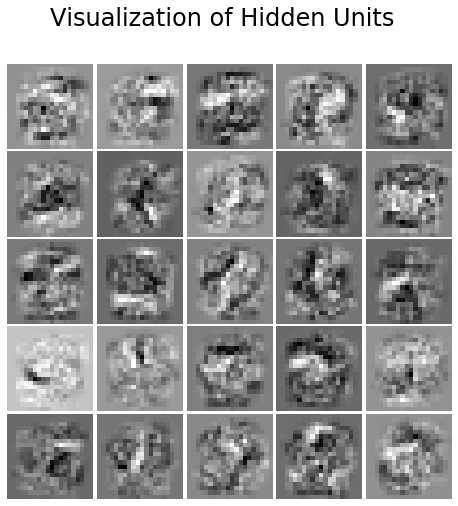

In [18]:
displayData(Theta1[:, 1:])
plt.suptitle('Visualization of Hidden Units', fontsize=24);